## MLP Final Project

Coleton Van Valkenburgh

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
%matplotlib inline
plt.style.use('bmh')

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
VRAM_ALLOC = 70_000# in MB, up to 80_000 if you are using the A100 GPU

if tf.config.list_physical_devices('GPU'):
    
    for GPU in tf.config.list_physical_devices('GPU'):
        print('Using GPU')
        tf.config.experimental.set_virtual_device_configuration(GPU,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=VRAM_ALLOC)])

Using GPU


In [4]:
# Load Training Data
X = np.load('data_train_corrected_final.npy')
t = np.load('labels_train_corrected_final.npy')
X.shape,t.shape

((270000, 6063), (6063,))

In [5]:
labels_names = ['Stop','Yield','Red Light','Green Light','Roundabout','Right Turn Only',
                'Do Not Enter','Crosswalk','Handicap Parking','No Parking']

In [6]:
#Randomly partition the data into training (10%) and test sets (90%)
X_training, X_test, t_training, t_test = train_test_split(X.T, t, shuffle=True, test_size=0.01)

X_train, X_val, t_train, t_val = train_test_split(X_training, t_training, shuffle=True, test_size=0.1)

X_train.shape, X_val.shape, X_test.shape, t_train.shape, t_val.shape, t_test.shape

((5401, 270000), (601, 270000), (61, 270000), (5401,), (601,), (61,))

In [7]:
# Converts the image array back into the size (N, H, W, D)
X_train = tf.constant(X_train.reshape((X_train.shape[0],300,300,3))) #Returns the images to their origial RGB configurations

X_val = tf.constant(X_val.reshape((X_val.shape[0],300,300,3))) #Returns the images to their origial RGB configurations

X_test = tf.constant(X_test.reshape((X_test.shape[0],300,300,3))) #Returns the images to their origial RGB configurations

X_train.shape, X_val.shape, X_test.shape

2022-07-28 09:04:25.035451: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 09:04:26.247912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 70000 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


(TensorShape([5401, 300, 300, 3]),
 TensorShape([601, 300, 300, 3]),
 TensorShape([61, 300, 300, 3]))

In [8]:
# Hyperparameters
lr = 0.001
num_of_epochs = 500 #Number of times will loop through the data
batch_size = 32 #Determines how the dataset is divided

In [9]:
IMG_SIZE = 150 # will rescale and normalize the images to (150,150,3) with pixcel ranges from (0-1) floats

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1/255.0)
])

In [10]:
# CNN Model

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300,300,3]),
    resize_and_rescale,
#    keras.layers.Conv2D(32, 7, activation='relu', padding='same', input_shape=[300,300,3]),
#    keras.layers.MaxPool2D(2),
#    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
#    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
#    keras.layers.MaxPool2D(2),
#    keras.layers.Flatten(),
    #keras.layers.Resizing(150, 150),
    keras.layers.Flatten(),
    keras.layers.Dense(5000, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [11]:
model.build(input_shape = ()) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 5000)              337505000 
_________________________________________________________________
batch_normalization (BatchNo (None, 5000)              20000     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              5001000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)              

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Nadam(learning_rate=lr),
             metrics=['accuracy'])

In [13]:
history = model.fit(X_train, t_train, epochs=num_of_epochs, batch_size=batch_size,
         validation_data=(X_val, t_val),
         callbacks=[keras.callbacks.EarlyStopping(patience=10), #Will stop the code early if no progress has been made on the validation set
                   keras.callbacks.ModelCheckpoint('CNN_checkpoint', save_best_only=True) #Will save model with best validation set
                   ])

2022-07-28 09:04:30.158665: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
  3/169 [..............................] - ETA: 7s - loss: 2.7779 - accuracy: 0.2396  

2022-07-28 09:04:32.357941: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


169/169 [==============================] - 10s 43ms/step - loss: 1.2587 - accuracy: 0.5825 - val_loss: 1.1882 - val_accuracy: 0.5923


2022-07-28 09:04:40.297229: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: CNN_checkpoint/assets
Epoch 2/500
169/169 [==============================] - 7s 42ms/step - loss: 0.8701 - accuracy: 0.7091 - val_loss: 1.5370 - val_accuracy: 0.5491
Epoch 3/500
169/169 [==============================] - 7s 42ms/step - loss: 0.7888 - accuracy: 0.7315 - val_loss: 1.2233 - val_accuracy: 0.6040
Epoch 4/500
169/169 [==============================] - 7s 43ms/step - loss: 0.7234 - accuracy: 0.7597 - val_loss: 1.1404 - val_accuracy: 0.6456
INFO:tensorflow:Assets written to: CNN_checkpoint/assets
Epoch 5/500
169/169 [==============================] - 7s 44ms/step - loss: 0.6668 - accuracy: 0.7758 - val_loss: 2.2178 - val_accuracy: 0.4992
Epoch 6/500
169/169 [==============================] - 7s 44ms/step - loss: 0.6059 - accuracy: 0.7932 - val_loss: 1.5840 - val_accuracy: 0.5657
Epoch 7/500
169/169 [==============================] - 7s 44ms/step - loss: 0.5720 - accuracy: 0.8117 - val_loss: 1.5454 - val_accuracy: 0.5657
Epoch 8/500
169/169 [=

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

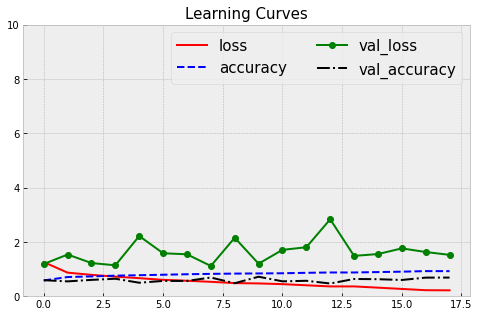

In [15]:
#Loss Function and Accuracy Plots
key_names = list(history.history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(8,5))
for i in range(len(key_names)):
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves', size=15);

In [16]:
model = keras.models.load_model('CNN_trial_1')

In [17]:
y_train = np.argmax(model.predict(X_train), axis=1)
y_test = np.argmax(model.predict(X_test), axis=1)

In [18]:
print(classification_report(t_train, y_train, target_names=labels_names))

print(classification_report(t_test, y_test, target_names=labels_names))

                  precision    recall  f1-score   support

            Stop       0.00      0.00      0.00       538
           Yield       0.00      0.00      0.00       553
       Red Light       0.00      0.00      0.00       516
     Green Light       0.00      0.00      0.00       548
      Roundabout       0.00      0.00      0.00       545
 Right Turn Only       0.00      0.00      0.00       512
    Do Not Enter       0.10      1.00      0.18       532
       Crosswalk       0.00      0.00      0.00       553
Handicap Parking       0.00      0.00      0.00       556
      No Parking       0.00      0.00      0.00       548

        accuracy                           0.10      5401
       macro avg       0.01      0.10      0.02      5401
    weighted avg       0.01      0.10      0.02      5401

                  precision    recall  f1-score   support

            Stop       0.00      0.00      0.00        10
           Yield       0.00      0.00      0.00         1
       Red

/apps/tensorflow/2.6.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.6.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.6.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.6.0/lib/pyth

In [19]:
#Saving the Model
#model.save('my_keras_model.h5')
#model = keras.models.load_model('my_keras_model.h5')